#  
<h1 style="font-size:250%; font-family:cursive; color:#ff6666;"> <b>1. Getting Data Ready <a id="0"></a></b></h1>

In [1]:
import os
import pathlib
from pathlib import Path 

### 1.1 Creating train and test directory and exploring them

In [2]:
image_path = Path("data/food-101")
train_dir  = image_path/"Train"
test_dir   = image_path/"Test"

#### Checking number of image samples in each set

In [3]:
print(f"Number of images in Training set is: {len(list(train_dir.glob('*/*.jpg')))}\nNumber of images in Testing set is: {len(list(test_dir.glob('*/*.jpg')))}")
# this is memory consuming as we have to make list here

Number of images in Training set is: 70700
Number of images in Testing set is: 30300


In [4]:
train_image_count = sum(1 for _ in train_dir.rglob('*.jpg'))
test_image_count = sum(1 for _ in test_dir.rglob('*.jpg'))

#rglob recursively seraches for .jpg file. 

print(f"Number of images in Training set is: {train_image_count}")
print(f"Number of images in Testing set is: {test_image_count}")

#memory efficient alternative

Number of images in Training set is: 70700
Number of images in Testing set is: 30300


### 1.2 Finding Class Labels and converting them to class index

In [5]:
class_names = sorted(os.listdir(train_dir)) 
class_to_idx = { name:i for i, name in enumerate(class_names)}

# <h1 style = "font-size:250%; family:'cursive'; color:#ff6666"> 2. Create DataLoader <a id=2></a></h1>

In [6]:
import torch
import torchvision
from torchvision import transforms
from torch import nn 

### 2.1 Create Transforms using pretrained model weights

In [7]:
# Before we Create dataloader lets select an pretrained model so that we can get the transforms applied on that model.
from torchvision.transforms import InterpolationMode
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
auto_transforms =transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure image is in RGB format
    transforms.Resize([288], interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop([288]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
auto_transforms

Compose(
    Lambda()
    Resize(size=[288], interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(288, 288))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

### 2.2 Create custom dataloader

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torch.utils.data import Dataset 
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random

#### Using ImageFolder for dataset

In [9]:
train_dataset_img = datasets.ImageFolder(root =train_dir,
                                         transform = auto_transforms,
                                         target_transform = None
)
#bad bad

In [10]:

class ImageDataset(Dataset):
    def __init__(self,target_dir,transform= None):
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes = sorted(os.listdir(target_dir))
        self.class_to_idx = {name:i for i,name in enumerate(self.classes)}
    
    def __len__(self):
        return(len(self.paths))

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        class_name = self.paths[idx].parent.stem
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        
        else:
            return img, class_idx
    
    

In [11]:
train_dataset = ImageDataset(target_dir=train_dir, transform = auto_transforms)
test_dataset = ImageDataset(target_dir=test_dir, transform=auto_transforms)

In [12]:
# Displaying some random Images from the custom dataset we created.
def disp_random_images(dataset,classes,n,seed):
    random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k =n)

    plt.figure(figsize=(16,8))

    for i, sample in enumerate(random_samples_idx):

        img,label = dataset[sample][0], dataset[sample][1]

        img_adjust = img.permute(1,2,0)

        plt.subplot(1,n,i+1)
        plt.imshow(img_adjust)
        plt.axis(False)
        title = f"Class: {classes[label]}"
        plt.title(title)
   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4285715].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].


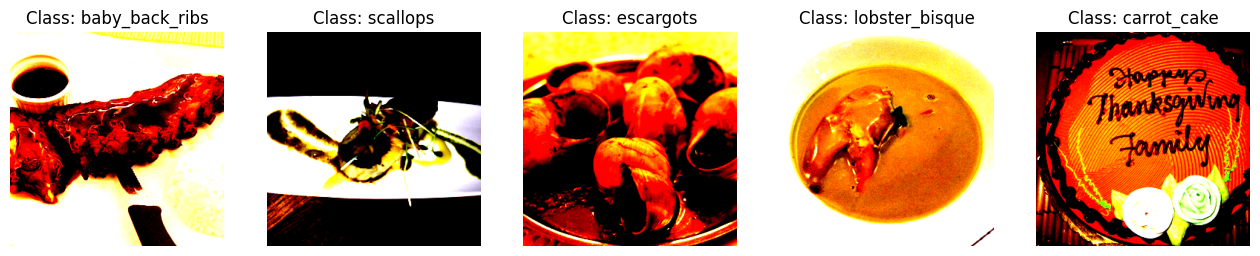

In [13]:
disp_random_images(train_dataset, class_names,5,None)

#### Now change the dataset into dataloader

In [14]:
train_dataloader = DataLoader( dataset = train_dataset,
                               batch_size = 32,
                               num_workers = os.cpu_count()-4,
                               shuffle = True,
                               pin_memory =True
)

test_dataloader = DataLoader( dataset = test_dataset,
                              batch_size =32,
                              num_workers = os.cpu_count()-4,
                              shuffle = False,
                              pin_memory = True

)

# <h1 style = "font-size:250%; family:'cursive'; color:#ff6666"> 3. Training Preparation <a id=2></a></h1>

In [15]:
from torchinfo import summary

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
epochs = 10
device

'cuda'

### Initializing pretrained model [ Effnet]

In [17]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model = torchvision.models.efficientnet_b2(weights=weights).to(device)

In [18]:
summary(model=model) 

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    │    └─MBConv: 3-5                                 612
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-6                                 6,004
│    │    └─MBConv: 3-7                                 10,710
│    │    └─MBConv: 3-8                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-9                                 16,518
│    │    └─MBConv: 3-10       

### **Freeze all the base layers**

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
# Checking the classifier layer of effnet b2

model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [21]:
# redefining classiifer layer as per our need
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

In [22]:
summary(model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 (864)
│    │    └─BatchNorm2d: 3-2                            (64)
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 (1,448)
│    │    └─MBConv: 3-5                                 (612)
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-6                                 (6,004)
│    │    └─MBConv: 3-7                                 (10,710)
│    │    └─MBConv: 3-8                                 (10,710)
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-9                                 (16,518)
│    │    └─MBC

#### **Define Loss function and optimizer**

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

#### **Setup Trainig and testing loop**

In [24]:
from tqdm import tqdm

In [25]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [26]:
def train(model, 
          train_dataloader,
          test_dataloader, 
          optimizer,
          loss_fn,
          epochs,
          device):

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [27]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  model.train()
  
  train_loss, train_acc= 0, 0
  
  for batch, (X,y) in enumerate(dataloader):
      X,y= X.to(device), y.to(device)
      
      #forward pass
      y_pred =  model(X)
      
      #calculate the loss
      loss =  loss_fn(y_pred, y)
      train_loss += loss.item()
      
      #optimizer zero grad
      optimizer.zero_grad()
      
      #loss backward
      loss.backward()
      
      #optimizer step
      optimizer.step()
      
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
      train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
      # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  print(f"X device: {X.device}")
  print(f"Model device: {next(model.parameters()).device}")
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1) #softmax gare ni na gare ni same thing
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [35]:
train(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              epochs=15,
              device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

X device: cuda:0
Model device: cuda:0
Epoch: 1 | train_loss: 2.4351 | train_acc: 0.4460 | test_loss: 1.8156 | test_acc: 0.5612
X device: cuda:0
Model device: cuda:0
Epoch: 2 | train_loss: 1.8752 | train_acc: 0.5371 | test_loss: 1.6961 | test_acc: 0.5799
X device: cuda:0
Model device: cuda:0
Epoch: 3 | train_loss: 1.7882 | train_acc: 0.5552 | test_loss: 1.6332 | test_acc: 0.5915


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
